In [ ]:
#check for order 0 reactions

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import anndata as an
from Bio import Entrez

from mebocost import mebocost

Warning (xlmhg): Failed to import "mhg_cython" C extension.
Warning (xlmhg): Failed to import the "mhg_cython" C extension.Falling back to the pure Python implementation, which is very slow.


In [2]:
os.chdir('/Users/elias/MEBOCOST')
os.getcwd()

'C:\\Users\\elias\\MEBOCOST'

In [3]:
adata = an.read_csv("/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/RNA_counts_vsn.csv").T

In [4]:
print(adata.shape)

(22, 14029)


In [5]:
adata.obs['state'] = ['H', 'T'] * 11
adata.obs['sample'] = adata.obs_names

In [10]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['sample'],
                        met_est = 'scFEA-balance',
                        config_path = '/Users/elias/MEBOCOST/mebocost.conf',
                        exp_mat=None,
                        cell_ann=None,
                        species='human',
                        met_pred='/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/balance_20221202-105743.csv',
                        met_enzyme=None,
                        met_sensor=None,
                        met_ann = None,
                        scFEA_ann=None,
                        compass_met_ann=None,
                        compass_rxn_ann=None,
                        gene_network=None,
                        gmt_path=None,
                        cutoff_exp='auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met='auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop=0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type=['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread=8
                        )

[December 06, 2022 16:12:21]: We get expression data with 14029 genes and 22 cells.
[December 06, 2022 16:12:21]: Data Preparation Done in 0.0270 seconds


In [11]:
## 【optional】only estimate metabolite abundance for cells using expression data
## this estimation actually included in infer_commu function, if you want 
## two steps include loading config and running estimator
mebo_obj._load_config_()
mebo_obj.estimator()

[December 06, 2022 16:12:26]: Load config and read data based on given species [human].
[December 06, 2022 16:12:30]: Estimtate metabolite level using scFEA-balance


AttributeError: 'str' object has no attribute 'columns'

In [40]:
scFEA_info = pd.read_csv('/Users/elias/MEBOCOST/data/scFEA/Human_M168_information.symbols.csv', index_col = 0)

In [49]:
met_pred = pd.read_csv('/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/RNA_counts_vsn_module168_cell22_batch22_LR0.008_epoch100_SCimpute_F_lambBal1_lambSca1_lambCellCor1_lambModCor_1e-2_20221202-105743.csv', index_col = 0)

In [ ]:
help(pd.DataFrame())

In [55]:
met_m_out = pd.Series()
met_m_in = pd.Series()
for i, line in scFEA_info.iterrows():
    m_out = line['Compound_OUT_ID'].split('+')
    m_in = line['Compound_IN_ID'].split('+')
    for m in m_out: ## out module
        if m in met_m_out:
            met_m_out[m] += '; '+i
        else:
            met_m_out[m] = i
    for m in m_in: ## in module
        if m in met_m_in:
            met_m_in[m] += '; '+i
        else:
            met_m_in[m] = i
met_summ = {}
ma = list(set(met_m_in.index.tolist()) & set(met_m_out.index.tolist())) ## all modules for iterate

In [51]:
scFEA_pred = met_pred

In [44]:
m = 'C00167'

In [52]:
m_out = list(set(met_m_out[m].split('; ')) & set(scFEA_pred.columns.tolist()))

In [53]:



## summarized module flux to metabolite level

for m in ma:
    m_out = list(set(met_m_out[m].split('; ')) & set(scFEA_pred.columns.tolist())) ## interect with scFEA result
    m_in = list(set(met_m_in[m].split('; ')) & set(scFEA_pred.columns.tolist()))
    m_level = pd.Series()
    if m_out:
        m_level = scFEA_pred[m_out].T.sum()
    if m_in:
        m_level -= scFEA_pred[m_in].T.sum()
    if len(m_level) != 0:
        met_summ[m] = m_level

In [83]:
## check the metabolite estimation result
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
## print head
met_mat.head()

,11H,11T,15H,15T,16H,16T,24H,24T,29H,29T,...,32H,32T,35H,35T,36H,36T,38H,38T,40H,40T
HMDB0003450,7.334185,6.019196,6.492423,6.399194,6.248581,6.227924,7.151560,6.018093,6.157389,7.856083,...,6.580335,9.791747,6.807847,6.059279,7.098380,6.457046,7.137893,6.094933,6.174884,7.255082
HMDB0003948,10.019340,9.154160,9.983697,9.302296,9.803275,9.213215,10.457295,9.705413,10.035145,10.621196,...,10.204081,10.469725,10.218747,10.110365,10.276022,10.175759,9.906467,9.540466,10.277954,10.319039
HMDB0003712,9.912834,8.934116,9.865514,9.166873,9.603663,9.024819,10.385821,9.506844,9.908258,10.355195,...,10.110958,10.236392,10.079325,9.934902,10.129517,9.935234,9.772425,9.372063,10.139653,10.061628
HMDB0003945,10.386249,9.445115,10.322515,9.590103,10.120905,9.555833,10.784089,9.989305,10.291160,10.831666,...,10.480472,10.805346,10.503844,10.331256,10.585099,10.476682,10.248427,9.831977,10.529165,10.537381
HMDB0003949,10.019340,9.154160,9.983697,9.302296,9.803275,9.213215,10.457295,9.705413,10.035145,10.621196,...,10.204081,10.469725,10.218747,10.110365,10.276022,10.175759,9.906467,9.540466,10.277954,10.319039


In [110]:
met_mat.to_csv("/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/met_mat_default.csv")

In [10]:
## metabolic communication inference
## Note: by default, this function include estimator for metabolite abundance
commu_res = mebo_obj.infer_commu(
                                n_shuffle=1000,
                                seed=12345, 
                                Return=True, 
                                thread=None,
                                save_permuation=False,
                                min_cell_number = 1
                            )

[December 02, 2022 14:25:09]: Load config and read data based on given species [human].
[December 02, 2022 14:25:28]: Estimtate metabolite level using scFEA-flux


AttributeError: 'str' object has no attribute 'columns'

In [85]:
# ### save 
mebocost.save_obj(obj = mebo_obj, path = '/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/bulk_vsn_test.pk')

In [47]:


## re-load the previous object if needed
mebo_obj = mebocost.load_obj('/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/bulk_vsn_test.pk')



[November 30, 2022 13:52:48]: Data Preparation Done in 0.0100 seconds


In [86]:
## check cutoff
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 7.216098308563232
metabolite_presence cutoff: 0.7512750625610352


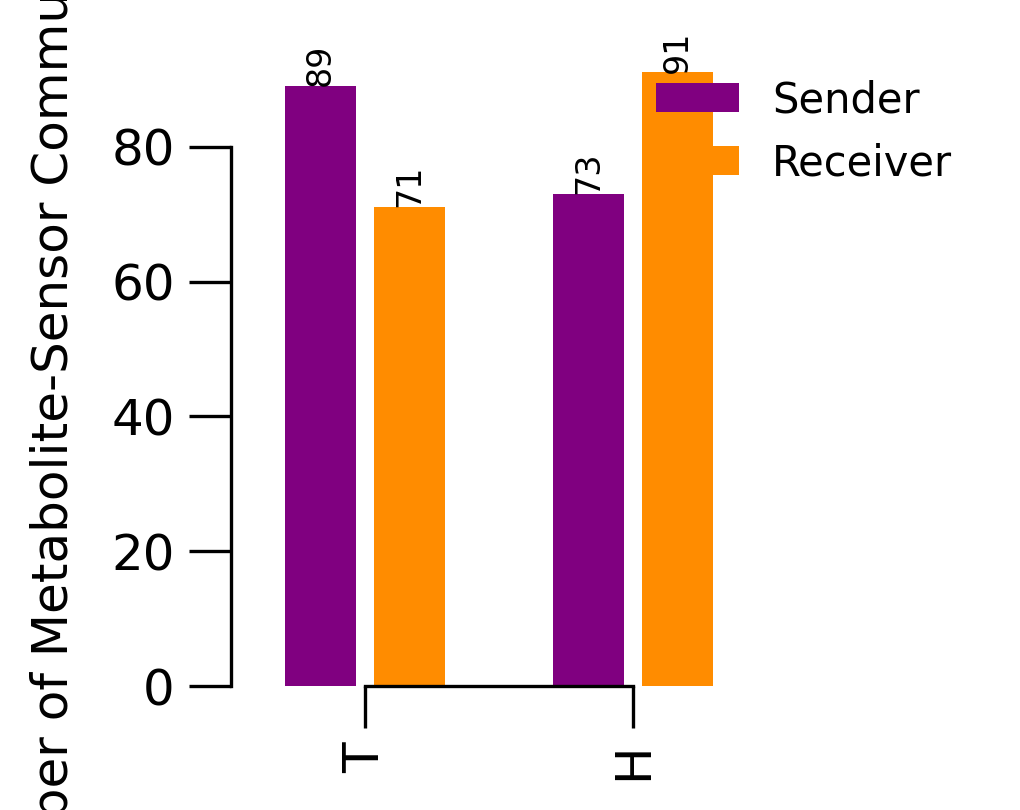

In [87]:
## sender and receiver event number
mebo_obj.eventnum_bar(
                    sender_focus=[],
                    metabolite_focus=[],
                    sensor_focus=[],
                    receiver_focus=[],
                    and_or='and',
                    pval_method='permutation_test_fdr',
                    pval_cutoff=0.05,
                    comm_score_col='Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize='auto',
                    save=None,
                    show_plot=True,
                    show_num = True,
                    include=['sender-receiver'],
                    group_by_cell=True,
                    colorcmap='tab20',
                    return_fig=False
                )

[November 30, 2022 18:57:35]: show communication in cells by network plot


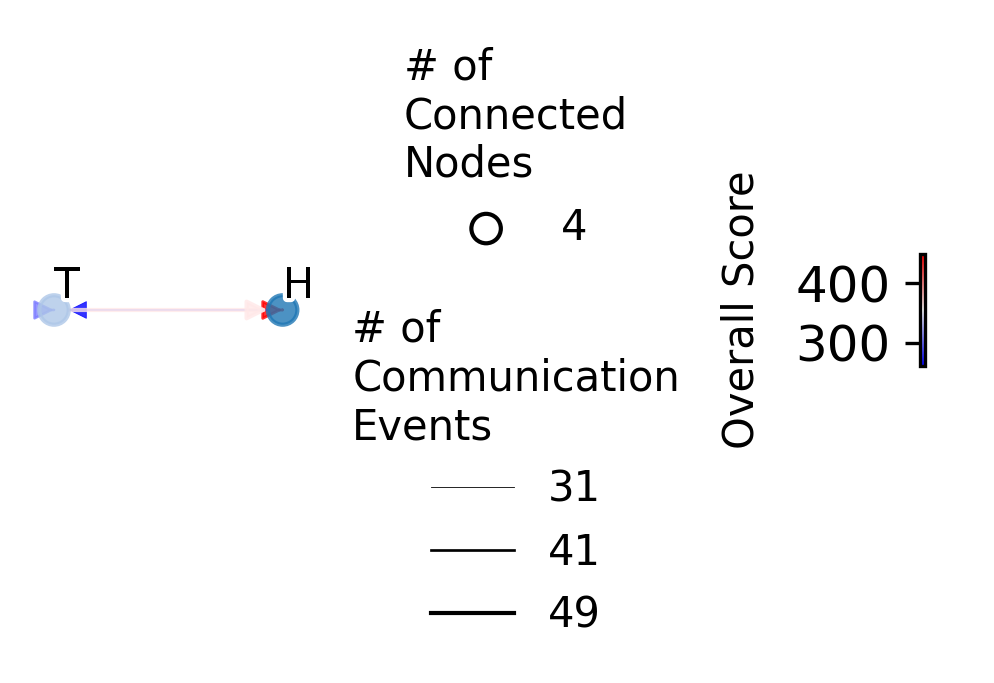

In [88]:
## circle plot to show communications between cell groups
mebo_obj.commu_network_plot(
                    sender_focus=[],
                    metabolite_focus=[],
                    sensor_focus=[],
                    receiver_focus=[],
                    and_or='and',
                    pval_method='permutation_test_fdr',
                    pval_cutoff=0.05,
                    node_cmap='tab20',
                    figsize='auto',
                    line_cmap='bwr',
                    line_color_vmin=None,
                    line_color_vmax=None,
                    linewidth_norm=(0.2, 1),
                    node_size_norm=(50, 200),
                    adjust_text_pos_node=True,
                    node_text_hidden = False,
                    node_text_font=10,
                    save=None,
                    show_plot=True,
                    comm_score_col='Commu_Score',
                    comm_score_cutoff=0,
                    text_outline=True,
                    return_fig=False
                )

### the "overall score" represent the sum of -log10(FDR) of detected metabolite-sensor communications between a pair of cell types

[November 30, 2022 18:57:46]: plot dot plot to show communication in cell type level


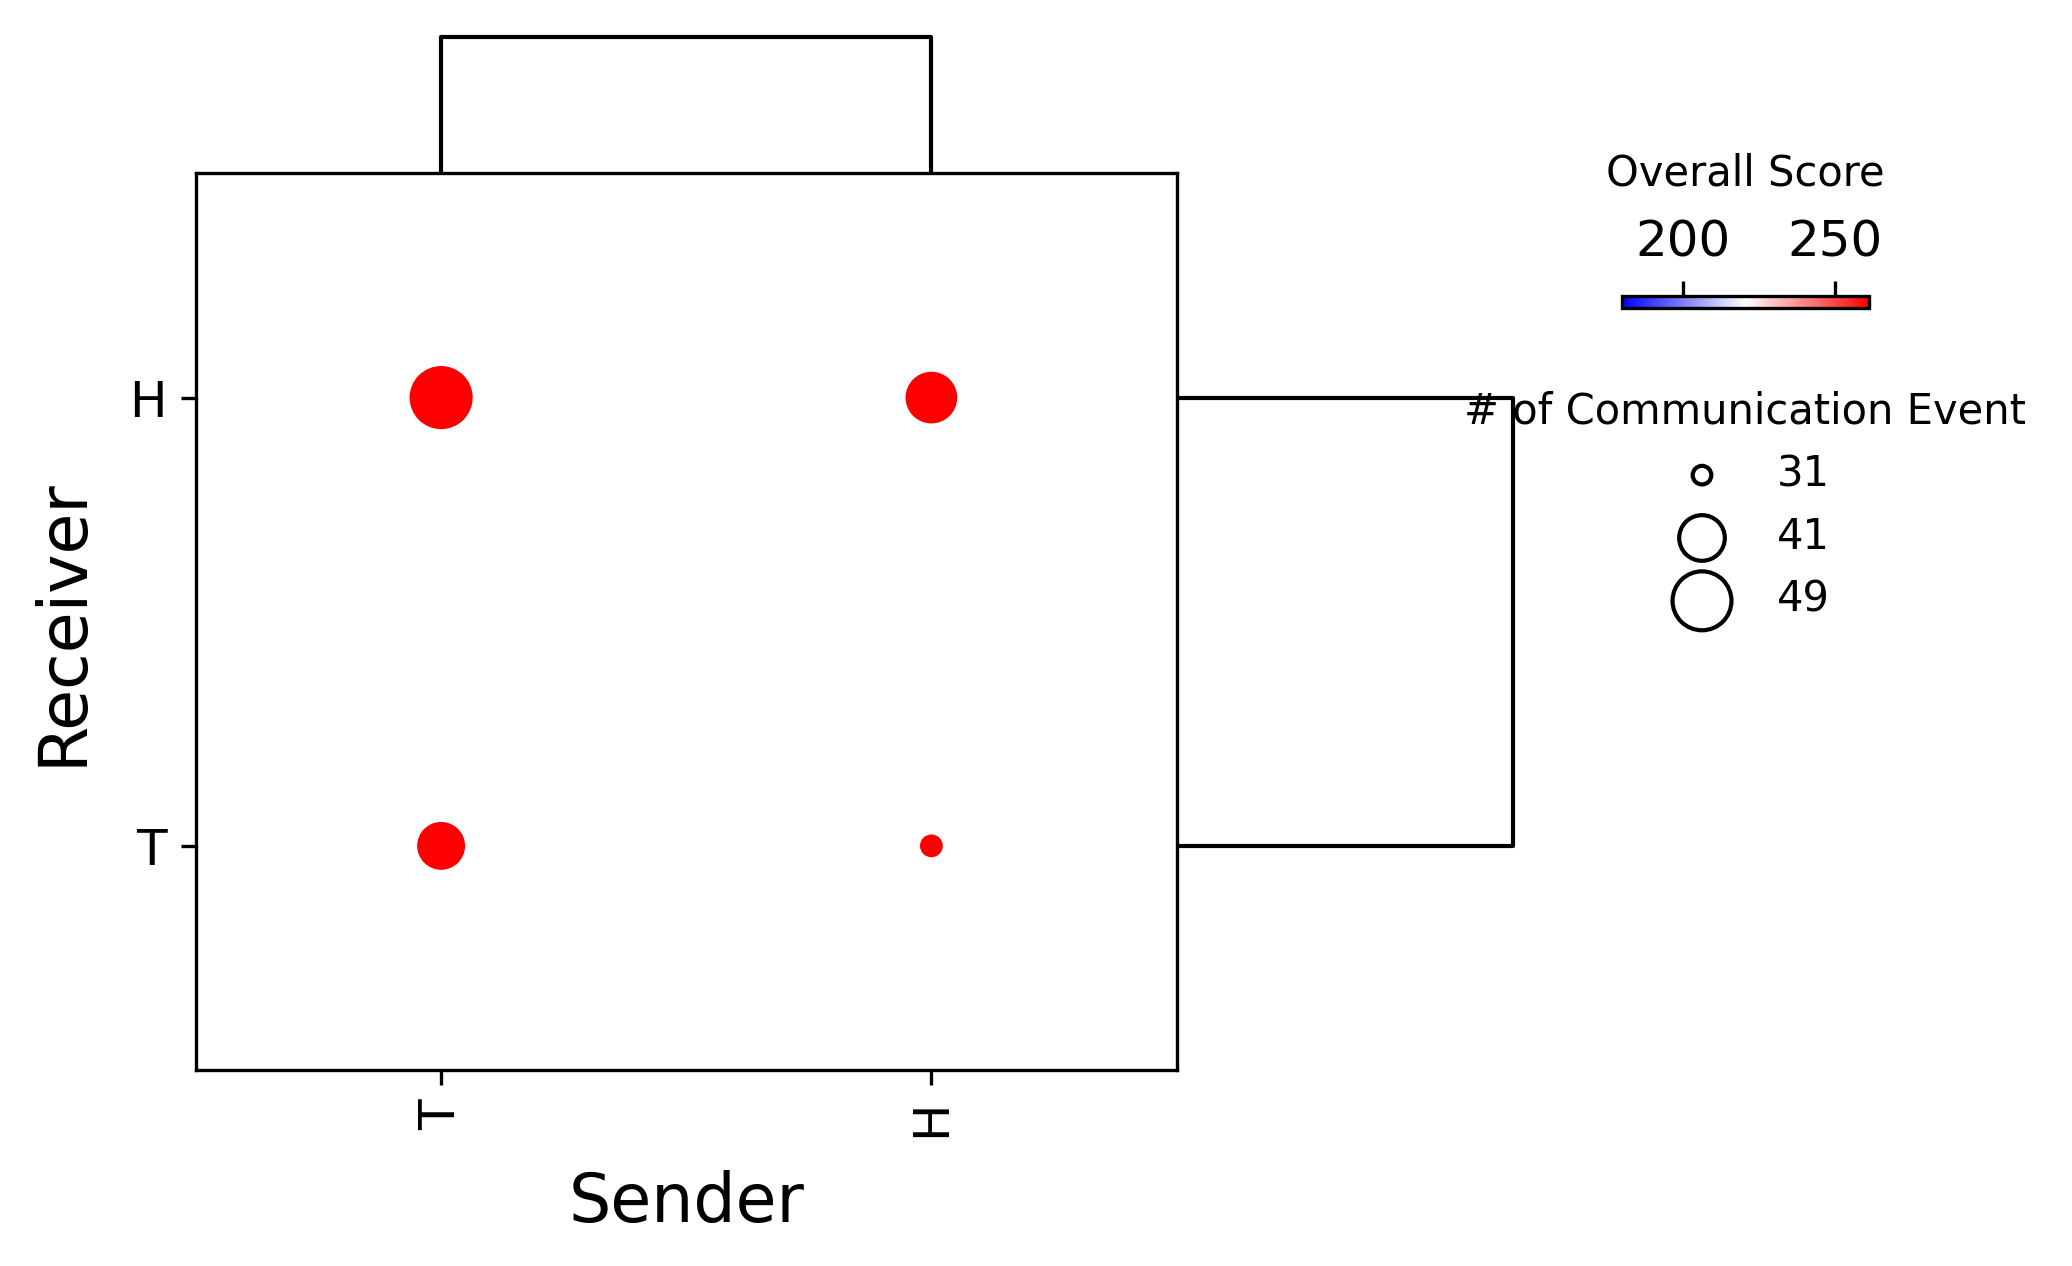

In [89]:
### dot plot to show the number of communications between cells

mebo_obj.count_dot_plot(
                        pval_method='permutation_test_fdr',
                        pval_cutoff=0.05,
                        cmap='bwr',
                        figsize='auto',
                        save=None,
                        dot_size_norm=(20, 200),
                        dot_color_vmin=None,
                        dot_color_vmax=200,
                        show_plot=True,
                        comm_score_col='Commu_Score',
                        comm_score_cutoff=0,
                        return_fig = False
                    )

In [90]:
## Malignant cell was focused, use receiver_focus=[] to include all cell types
mebo_obj.commu_dotmap(
                sender_focus=[],
                metabolite_focus=[],
                sensor_focus=[],
                receiver_focus=['Malignant'],
                and_or='and',
                pval_method='permutation_test_fdr',
                pval_cutoff=0.05,
                figsize='auto',
                cmap='bwr',
                node_size_norm=(10, 150),
                save=None,
                show_plot=True,
                comm_score_col='Commu_Score',
                comm_score_cutoff=0,
                swap_axis = False,
                return_fig = False
                )

[November 30, 2022 18:57:56]: plot heatmap for significant result
[November 30, 2022 18:57:56]: No enough data to show with your filtering!


[November 30, 2022 18:58:03]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

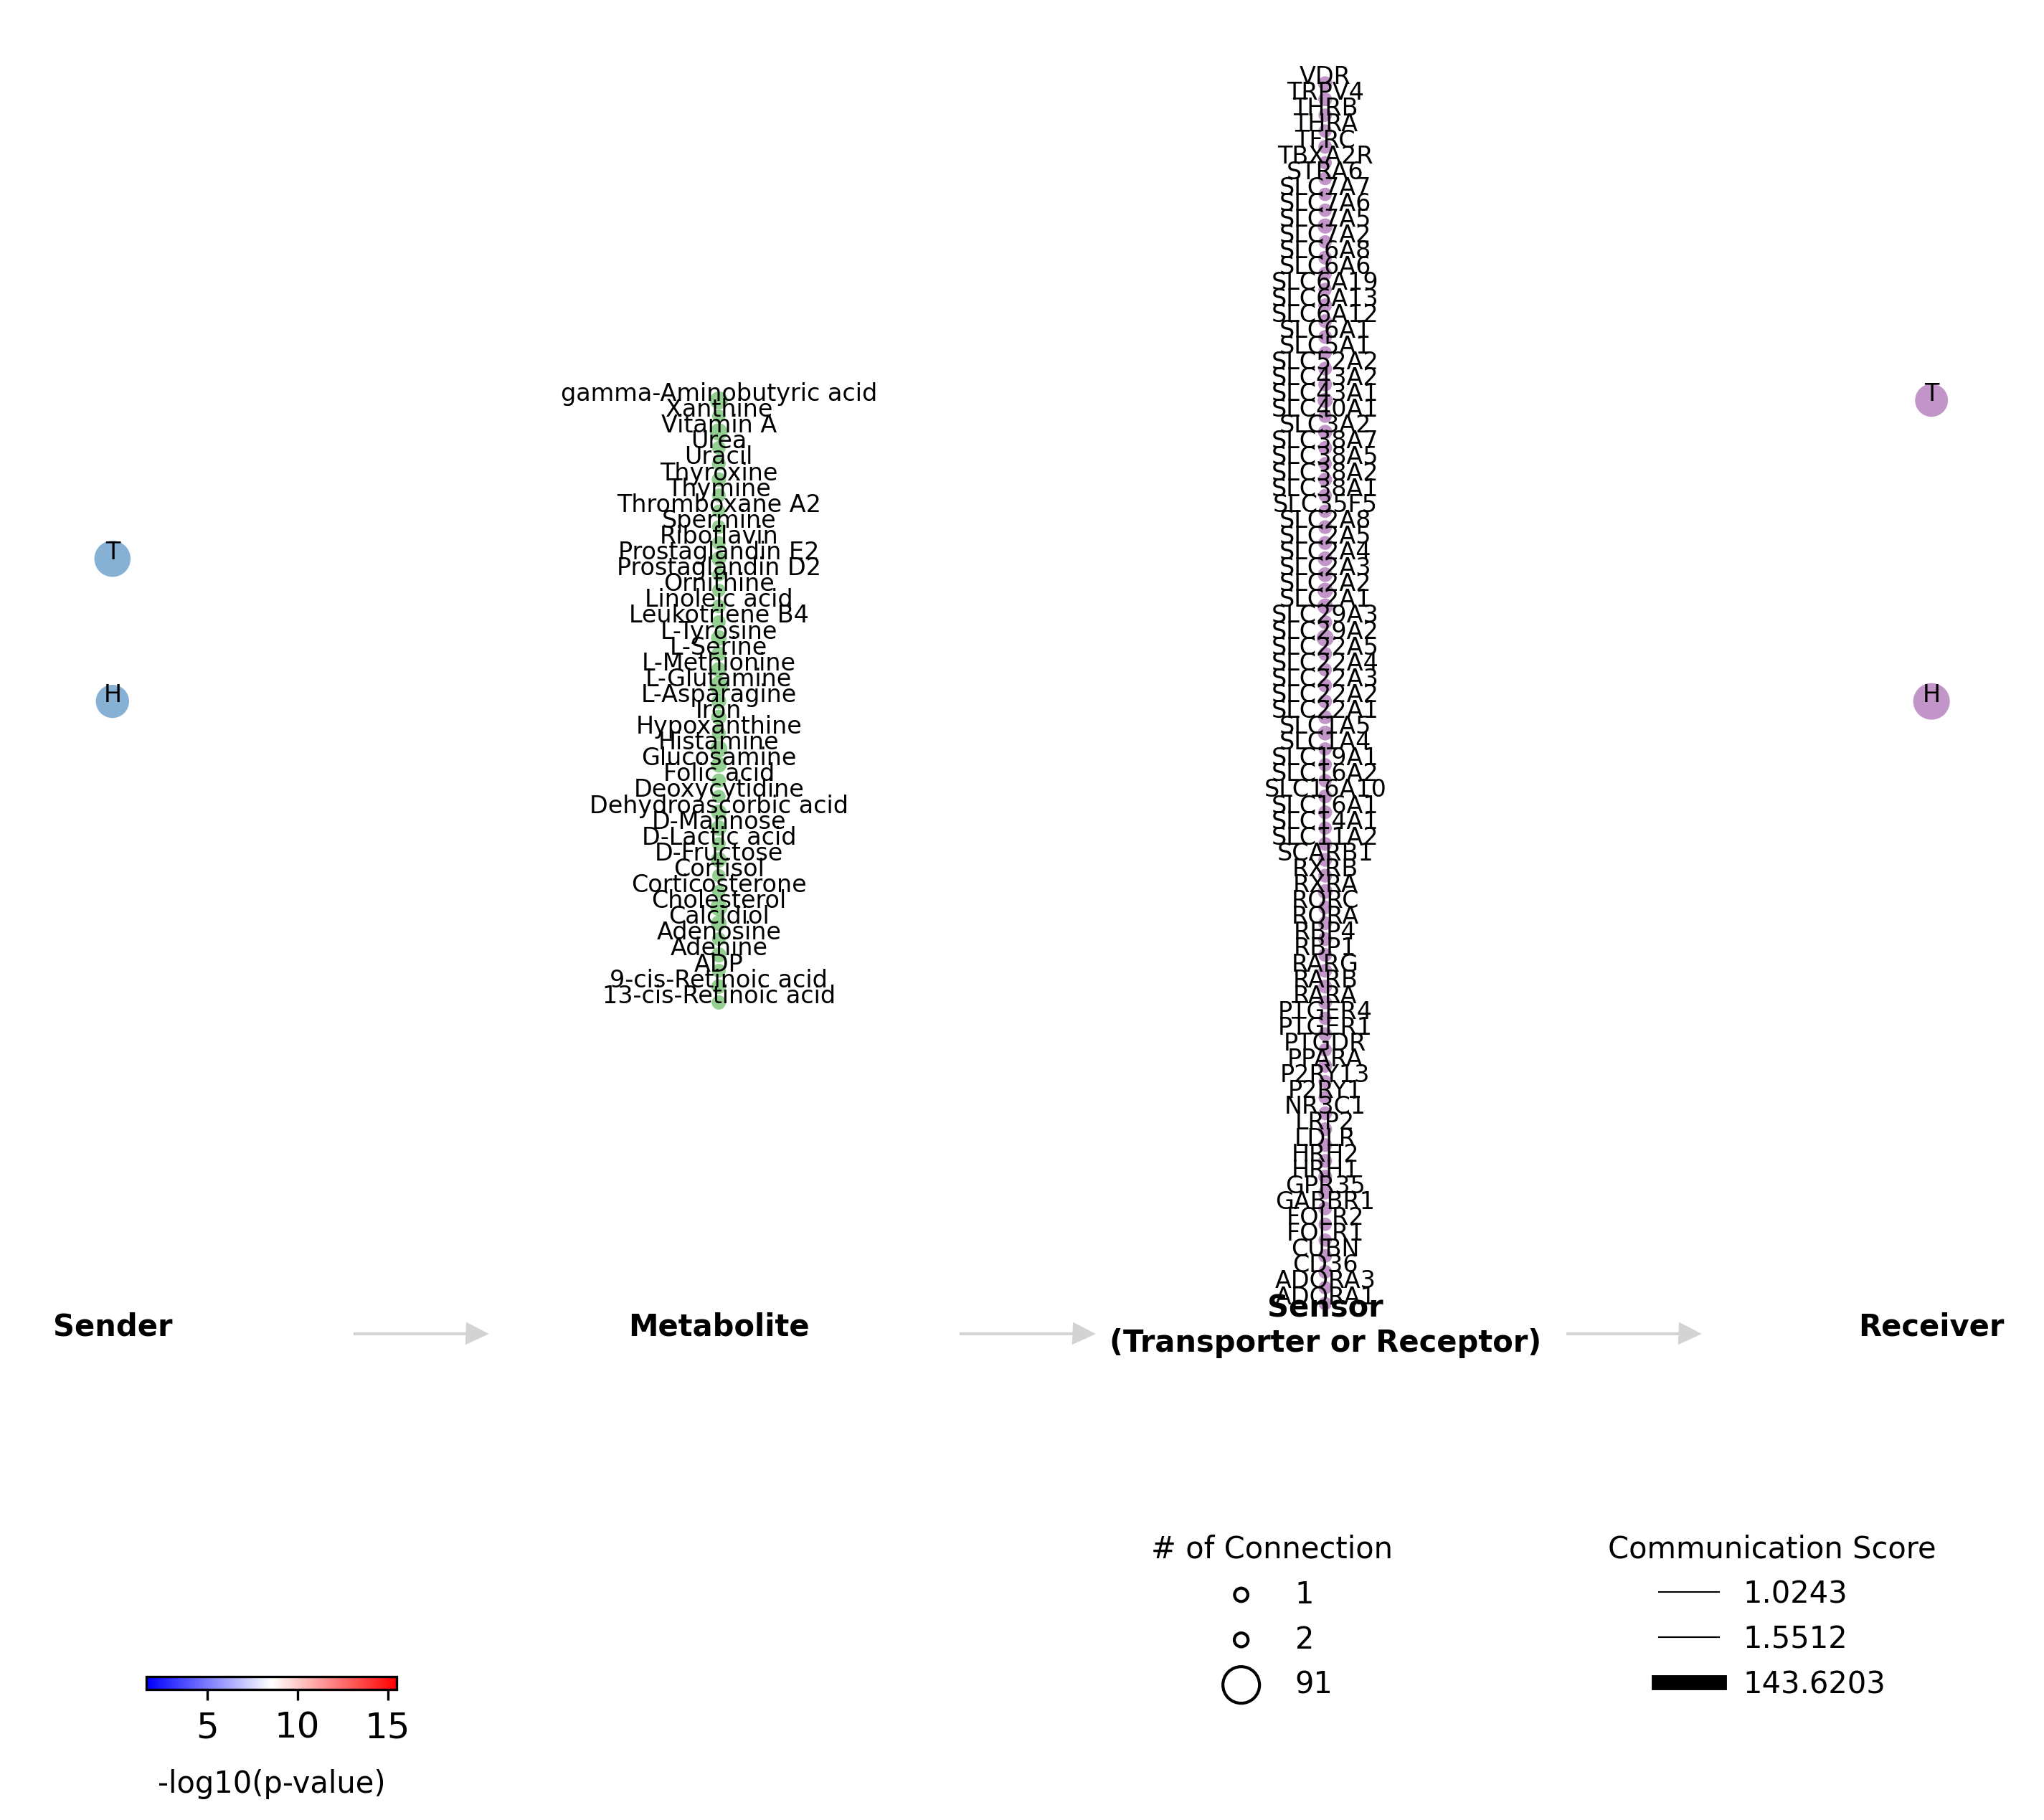

In [91]:
## Malignant cell was focused, use receiver_focus=[] to include all cell types
mebo_obj.FlowPlot(
                pval_method='permutation_test_fdr',
                pval_cutoff=0.05,
                sender_focus=[],
                metabolite_focus=[],
                sensor_focus=[],
                receiver_focus=['Malignant'],
                remove_unrelevant = False,
                and_or='and',
                node_label_size=8,
                node_alpha=0.6,
                figsize='auto',
                node_cmap='Set1',
                line_cmap='bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm=(20, 150),
                linewidth_norm=(0.5, 5),
                save=None,
                show_plot=True,
                comm_score_col='Commu_Score',
                comm_score_cutoff=0,
                text_outline=False,
                return_fig = False
            )

[November 30, 2022 18:58:37]: Warnings: no sensors to plot
[November 30, 2022 18:58:37]: Find metabolites ['9-cis-Retinoic acid', '13-cis-Retinoic acid', 'Adenosine', 'Adenine', 'ADP'] to plot violin


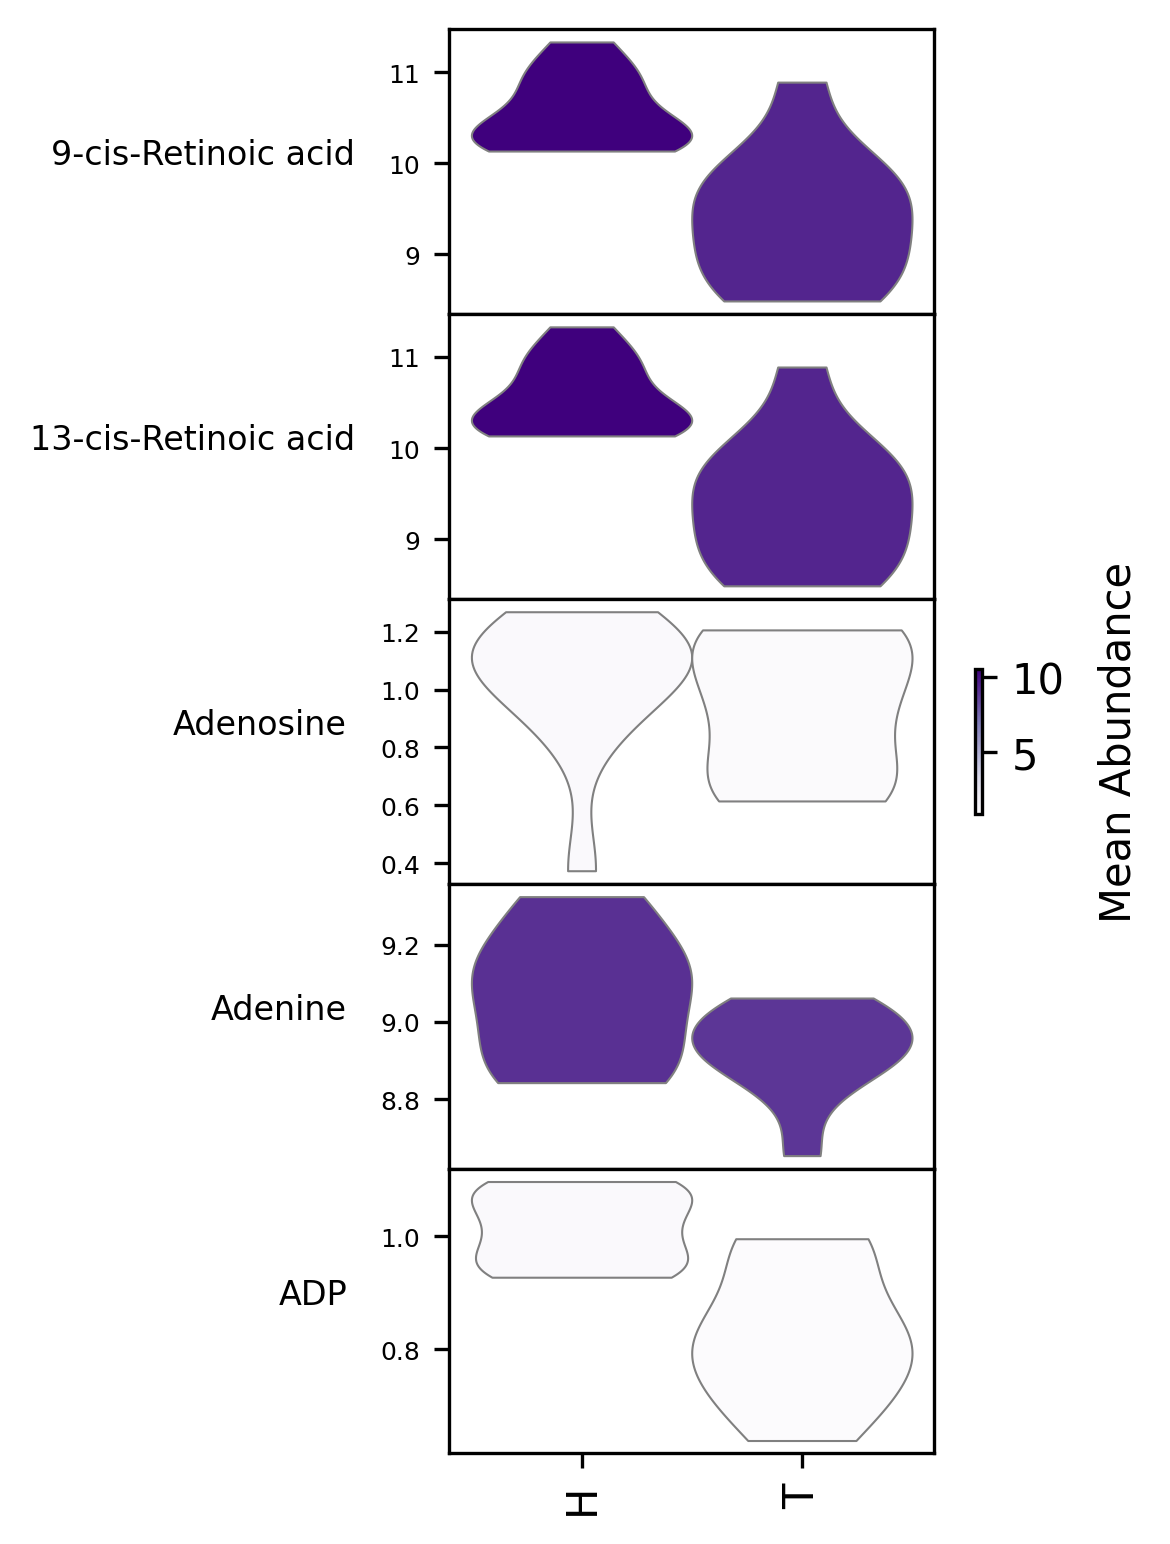

In [93]:
## violin plot to show the estimated metabolite abundance of informative metabolties in communication
### here we show five significant metabolites,
### users can pass several metabolites of interest by provide a list
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met=good_met[:5], ## only top 5 as example
                    cell_focus=[],
                    cmap=None,
                    vmin=None,
                    vmax=None,
                    figsize='auto',
                    cbar_title='',
                    save=None,
                    show_plot=True
                    )

[November 30, 2022 18:58:55]: Find genes Index(['ADORA3', 'ADORA1', 'CUBN', 'FOLR1', 'CD36'], dtype='object') to plot violin


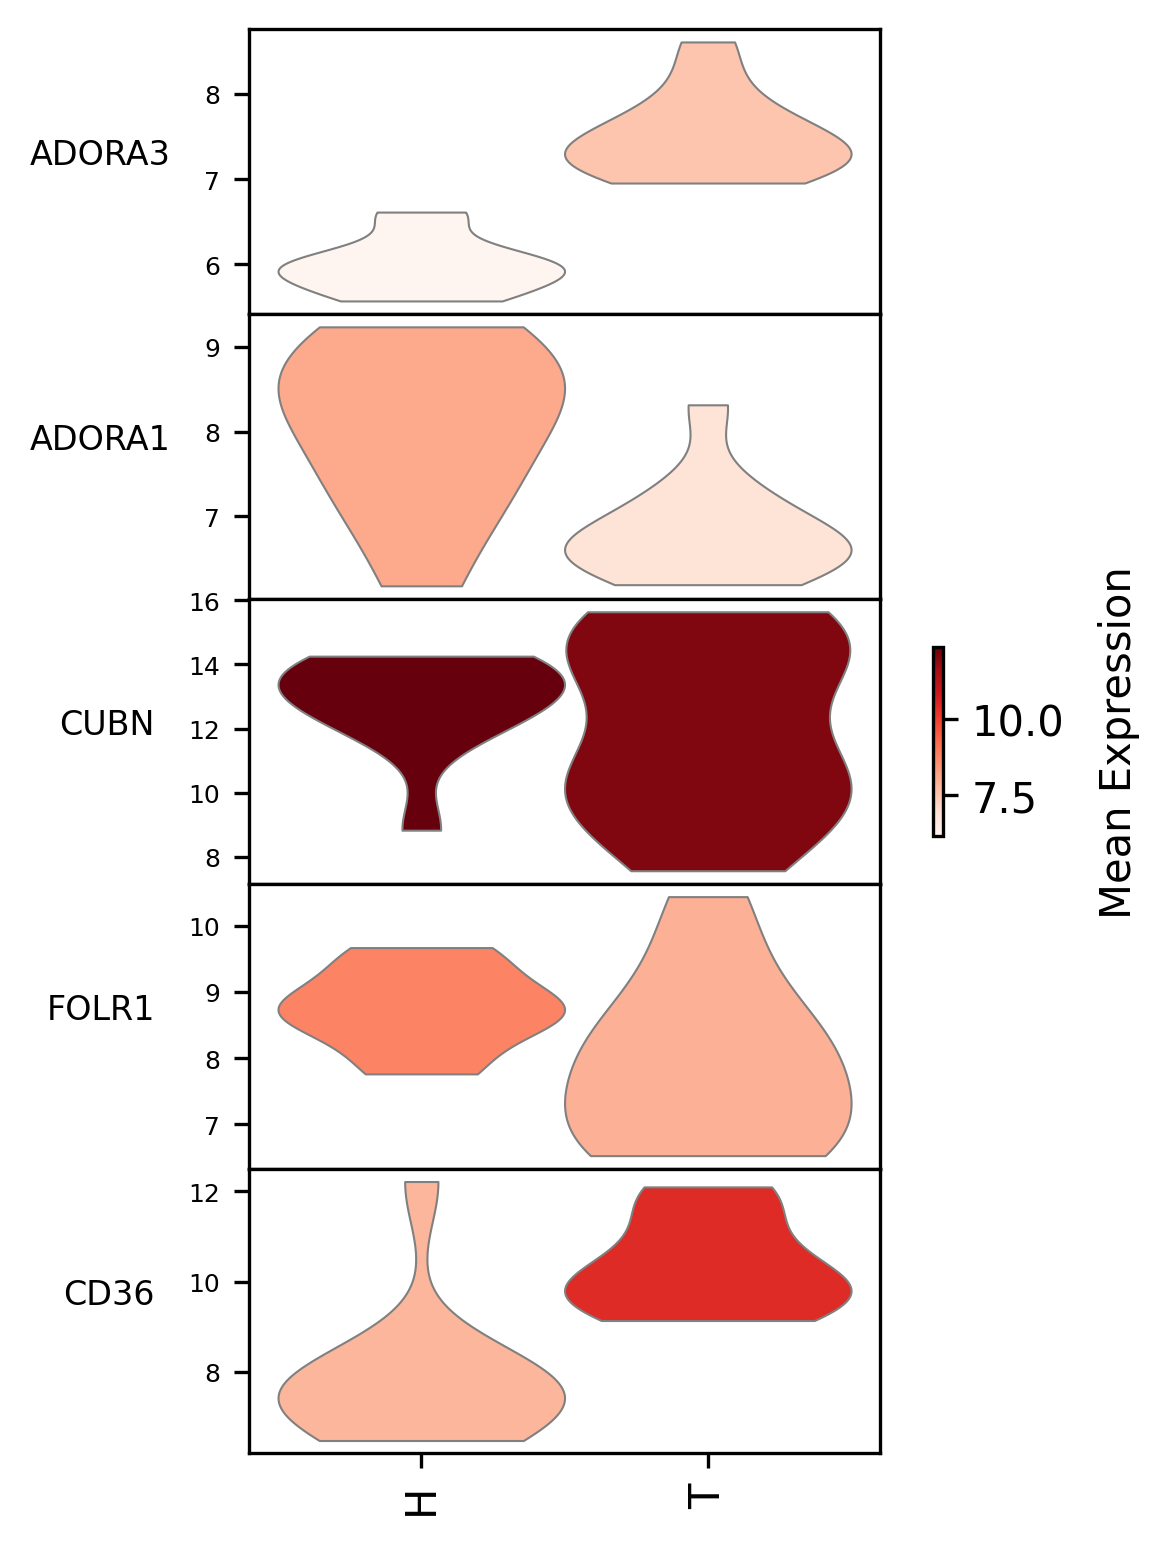

[November 30, 2022 18:58:56]: Warnings: no metabolites to plot


In [94]:
## violin plot to show the expression of informative sensors in communication

good_sensor = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Sensor'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met=good_sensor[:5],## only top 5 as example
                    cell_focus=[],
                    cmap=None,
                    vmin=None,
                    vmax=None,
                    figsize='auto',
                    cbar_title='',
                    save=None,
                    show_plot=True
                    )

In [56]:
### the updated and tidy communication result is in object, can be retreved by:
commu_res = mebo_obj.commu_res.copy()
## filter by FDR less than 0.05
commu_res = commu_res[commu_res['permutation_test_fdr']<=0.05]
## write to tsv file
commu_res.to_csv('/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/communication_result.tsv', sep = '\t', index = None)

In [57]:
mebo_obj.eventnum_bar(
                    sender_focus=[],
                    metabolite_focus=[],
                    sensor_focus=[],
                    receiver_focus=[],
                    and_or='and',
                    pval_method='permutation_test_fdr',
                    pval_cutoff=0.05,
                    comm_score_col='Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize='auto',
                    ## Note that filename passed by save parameter:
                    save='/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/mebocost_eventnum.pdf',
                    show_plot=False,
                    show_num = True,
                    include=['sender-receiver'],
                    group_by_cell=True,
                    colorcmap='tab20',
                    return_fig=False
                )

In [58]:
fig = mebo_obj.eventnum_bar(
                    sender_focus=[],
                    metabolite_focus=[],
                    sensor_focus=[],
                    receiver_focus=[],
                    and_or='and',
                    pval_method='permutation_test_fdr',
                    pval_cutoff=0.05,
                    comm_score_col='Commu_Score',
                    comm_score_cutoff = 0,
                    cutoff_prop = 0.25,
                    figsize='auto',
                    save=None,
                    show_plot=False,
                    show_num = True,
                    include=['sender-receiver'],
                    group_by_cell=True,
                    colorcmap='tab20',
                    return_fig=False
                )
## save figure
fig.savefig('/Users/elias/Documents/Praktika/Julio_Saez-Rodriguez/Python/mebocost_eventnum.pdf')

AttributeError: 'NoneType' object has no attribute 'savefig'

In [ ]:
## here, users can click and plot figures

## interactive view module mimic a website but all go with our default parameters

mebo_obj.communication_in_notebook(pval_method='permutation_test_fdr',
                                    pval_cutoff=0.05,
                                    comm_score_col='Commu_Score',
                                    comm_score_cutoff=None,
                                    cutoff_prop=None)

In [61]:
mebo_obj.infer_pathway(
                    pval_method='permutation_test_fdr',
                    pval_cutoff=0.05,
                    commu_score_cutoff=0,
                    commu_score_column='Commu_Score',
                    min_term=15,
                    max_term=500,
                    thread=None,
                    sender_focus=[],
                    metabolite_focus=[],
                    sensor_focus=[],
                    receiver_focus=[],
                    Return_res=False
                    )

[November 30, 2022 14:25:36]: Read gene set from GMT file
[November 30, 2022 14:25:36]: Weight gene expression by gene network score of sensor
[November 30, 2022 14:26:33]: Weighted expression deconvolution to metabolite-sensor events
[November 30, 2022 14:26:33]: 134 sensor-receiver pairs
[November 30, 2022 14:34:05]: Weighted expression deconvolution to sender-receiver events
[November 30, 2022 14:34:05]: 102 sender-receiver pairs
[November 30, 2022 14:34:08]: Enrichment for significant sensor in receiver cell
[November 30, 2022 14:34:08]: Thread: 8


TypeError: get_xlmhg_stat() takes from 3 to 4 positional arguments but 6 were given

In [ ]:
### retreve pathways for sensor in receiver cells
## the result saved by sensor ~ receiver as a python dict
## show all the sensor~receivers
print('All sensor ~ receivers:', mebo_obj.enrich_result['sensor_res'].keys())

In [ ]:


## retreve pathway enrichment for one sensor receiver pair
sensor_receiver = 'HRH4 ~ CD8Tex'
mebo_obj.enrich_result['sensor_res'][sensor_receiver]['mHG_res']



In [ ]:
### similarily for pathways between a pair of cells which are sender and receiver cells
## show all the sensor~receivers
print('All sender ~ receiver:', mebo_obj.enrich_result['cellpair_res'].keys())

In [ ]:
## retreve pathways for one sensor receiver pair
sender_receiver = 'Endothelial ~ Malignant'
mebo_obj.enrich_result['cellpair_res'][sender_receiver]['mHG_res']

In [ ]:
## check significant pathways for a sensor in receiver cell
## a interesting sensor in receiver cell should be defined by users,
## Visualization of communications in Demo_Communication_Predict tutorial will help to users.

## here, take SLC1A5 in Malignant cells as an example
mebo_obj.pathway_scatter(
                            a_pair='SLC1A5 ~ Malignant',
                            pval_cutoff=0.05,
                            ES_cutoff=0,
                            cmap='cool',
                            vmax=None,
                            vmin=None,
                            figsize='auto',
                            title='',
                            maxSize=500,
                            minSize=15,
                            save=None,
                            show_plot=True
                        )

In [ ]:
## check pathway for a pair of sender and receiver
## sender is Endothelial and receiver is Malignant
mebo_obj.pathway_scatter(
                            a_pair='Endothelial ~ Malignant',
                            pval_cutoff=0.05,
                            ES_cutoff=0,
                            cmap='cool',
                            vmax=None,
                            vmin=None,
                            figsize='auto',
                            title='',
                            maxSize=500,
                            minSize=15,
                            save=None,
                            show_plot=True
                        )

In [ ]:
mebo_obj.pathway_stacked_bar(
                        pair1='SLC38A2 ~ Malignant',
                        pair2='SLC1A5 ~ Malignant',
                        pval_cutoff=0.05,
                        ES_cutoff=0,
                        cmap='spring_r',
                        vmax=None,
                        vmin=None,
                        figsize='auto',
                        title='',
                        maxSize=500,
                        minSize=15,
                        colors=['#CC6677', '#1E90FF'],
                        save=None,
                        show_plot=True,
                        return_fig=False
                        )

In [ ]:
### here taking sender ~ receiver as an example
mebo_obj.pathway_multi_dot(
                        pairs = ['Malignant ~ Malignant', 'Mast ~ Malignant', 'Endothelial ~ Malignant'],
                        pval_cutoff=0.05,
                        ES_cutoff=0,
                        cmap='Spectral_r',
                        vmax=None,
                        vmin=None,
                        node_size_norm=(20, 100),
                        figsize='auto',
                        title='',
                        maxSize=500,
                        minSize=15,
                        save=None,
                        show_plot=True,
                        swap_axis=True,
                        return_fig=False
                    )

In [ ]:
## here taking 'Estrogen signaling pathway' in 'SLC1A5 ~ Malignant' as an example
mebo_obj.pathway_ES_plot(
                        a_pair='SLC1A5 ~ Malignant',
                        pathway='Estrogen signaling pathway',
                        figsize=(8, 3.5),
                        dot_color='#1874CD',
                        curve_color='black',
                        title='',
                        save=None,
                        show_plot=True,
                        return_fig=False,
                        return_data=False
                    )